# SMS Spam Detection Using NLP and ML

# Introduction

- Natural language processing (NLP) is a subfield of computer science and artificial intelligence concerned with the interactions between computers and human (natural) languages.
- In this project, we will try to build a simple classifier using machine learning which will help in identifying whether a given SMS is a spam or not.

# Context

- The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

# Content

- The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

# 1. Importing Dependencies

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sk-learn Libraries 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# NLP Libraries
import re
import itertools
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Other Libraries
import string
from collections import Counter

# 2. Reading the dataset

In [2]:
# Reading the data
data = pd.read_csv('spam.csv', encoding = 'latin-1')
data.dropna(how = "any", inplace = True, axis = 1)
data.columns = ['label', 'message']
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 3. Exploratory Data Analysis (EDA)

In [3]:
# Let's check out some of the stats with some plots and the built-in methods in pandas!
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
# Let's use groupby to use describe by label, this way we can begin to think about the features that separate 
# ham and spam!

data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

**Observations**
- We have 4825 ham messages and 747 spam messages

In [5]:
# convert label to a numerical variable

data['numeric_label'] = data.label.map({'ham':0, 'spam':1})
data.head()

,label,message,numeric_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
# Let's make a new column to detect how long the text messages are:
data['message_length'] = data['message'].apply(len)
data.head()

,label,message,numeric_label,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [7]:
# Analysing the 'message_length' feature
data['message_length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: message_length, dtype: float64

In [8]:
# Max is 910 characters, let's use masking to find this message
data[data['message_length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

[Text(0.5, 0, 'Length Class'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'SPAM')]

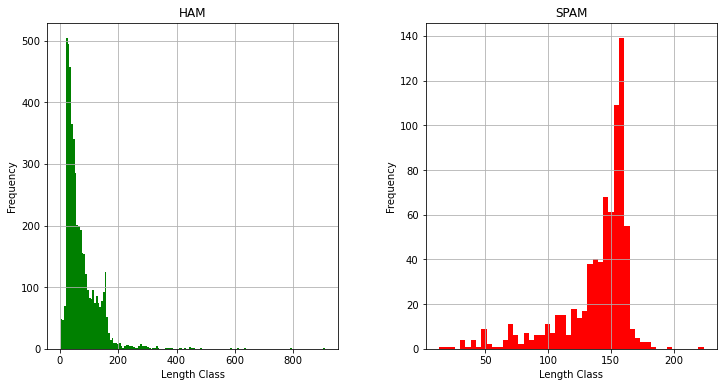

In [9]:
# Lets see if message length is a distinguishing feature between ham and spam:

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

data[data['label'] == 'ham'].hist(column = 'message_length', bins = 150,ax = ax[0], color = 'green')
ax[0].set(xlabel = 'Length Class', ylabel = 'Frequency', title = 'HAM')

data[data['label'] == 'spam'].hist(column = 'message_length', bins = 50, ax = ax[1], color = 'red')
ax[1].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'SPAM')

**Observations:**
- Thats interesting! Through the basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [10]:
# Lets Look statastically
print(data[data.label == 'ham'].describe())
print('*'*110)
print(data[data.label == 'spam'].describe())

       numeric_label  message_length
count         4825.0     4825.000000
mean             0.0       71.023627
std              0.0       58.016023
min              0.0        2.000000
25%              0.0       33.000000
50%              0.0       52.000000
75%              0.0       92.000000
max              0.0      910.000000
**************************************************************************************************************
       numeric_label  message_length
count          747.0      747.000000
mean             1.0      138.866131
std              0.0       29.183082
min              1.0       13.000000
25%              1.0      132.500000
50%              1.0      149.000000
75%              1.0      157.000000
max              1.0      224.000000


# 4. Preprocessing

- Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task.
- There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

## Data Cleaning

- text_preprocessing() function takes a sentence as it’s input and returns a cleaned sentence. This function takes care of the following

In [11]:
# Defining Certain Functions
def text_preprocessing(message):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in message if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [12]:
# Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the
# normal text strings in to a list of tokens (words that we actually want).

data['cleaned_message'] = data.message.apply(text_preprocessing)
data.head()

,label,message,numeric_label,message_length,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [13]:
# Lets visualise the most_common words from the data

In [14]:
words = data[data.label == 'ham'].cleaned_message.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94)]


In [15]:
words = data[data.label == 'spam'].cleaned_message.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


### Train_Test_Splitting

In [16]:
x = data.cleaned_message
y = data.numeric_label
print(x.shape)
print(y.shape)

(5572,)
(5572,)


In [17]:
# split X and y into training and testing sets 

x_train, x_test, y_train, y_test = train_test_split (x, y, random_state = 1, test_size = 0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457,)
(1115,)
(4457,)
(1115,)


In [18]:
x_train

1642                             Sleeping nt feeling well
2899                 Come aftr ltDECIMALgt cleaning house
480                                        Almost see sec
3485                                Yeah probably earlier
157     Hello love get interview today happy good boy ...
                              ...                        
905                    Hey whats charles sorry late reply
5192       Oh oh Den muz change plan liao Go back yan jiu
3980                        Huh cant thk oredi many pages
235                         printed oh ltgt come upstairs
5157                                         K k sms chat
Name: cleaned_message, Length: 4457, dtype: object

In [19]:
y_train

1642    0
2899    0
480     0
3485    0
157     0
       ..
905     0
5192    0
3980    0
235     0
5157    0
Name: numeric_label, Length: 4457, dtype: int64

In [20]:
x_test

1078                                       Convey regards
4028                         Û anyway many good evenings
958     sort code acc bank natwest reply confirm ive s...
4642                                Sorry din lock keypad
4674    Hi babe Chloe r smashed saturday night great w...
                              ...                        
324                                               problem
1163    New Theory Argument wins SITUATION loses PERSO...
86      real getting yo need tickets one jacket done a...
4214                                      dear sleeping P
90      Yeah DonÛ÷t stand close tho youÛ÷ll catch so...
Name: cleaned_message, Length: 1115, dtype: object

In [21]:
y_test

1078    0
4028    0
958     0
4642    0
4674    1
       ..
324     0
1163    0
86      0
4214    0
90      0
Name: numeric_label, Length: 1115, dtype: int64

## Vectorization

### 1. Bag - of - Words 

- Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

- Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

- We'll do that in three steps using the bag-of-words model:
    1. Count how many times does a word occur in each message (Known as term frequency)
    2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
    3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)


In [22]:
# Instantiate the vectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range = (1, 3), max_df = 0.5, min_df = 2)

# Learn the training data vocabulary, then use it to create a document-term matrix
bow_train = cv.fit_transform(x_train)

In [23]:
print('Shape of Sparse Matrix: ', bow_train.shape)
print('Amount of Non-Zero occurences: ', bow_train.nnz)

Shape of Sparse Matrix:  (4457, 9445)
Amount of Non-Zero occurences:  44636


In [24]:
# Transform test data (using fitted vocabulary) into a document-term matrix
bow_test = cv.transform(x_test)
bow_test

<1115x9445 sparse matrix of type '<class 'numpy.int64'>'
	with 8865 stored elements in Compressed Sparse Row format>

In [25]:
print('Shape of Sparse Matrix: ', bow_test.shape)
print('Amount of Non-Zero occurences: ', bow_test.nnz)

Shape of Sparse Matrix:  (1115, 9445)
Amount of Non-Zero occurences:  8865


### 2. TF-IDF

- TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. 
- This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. 
- The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 
- Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

In [26]:
# Instantiate the vectorizer
tv = TfidfTransformer()

# Learn the training data vocabulary, then use it to create a document-term matrix
tfidf_train = tv.fit_transform(bow_train)

In [27]:
print('Shape of Sparse Matrix: ', tfidf_train.shape)
print('Amount of Non-Zero occurences: ', tfidf_train.nnz)

Shape of Sparse Matrix:  (4457, 9445)
Amount of Non-Zero occurences:  44636


In [28]:
# Transform test data (using fitted vocabulary) into a document-term matrix
tfidf_test = tv.transform(bow_test)
tfidf_test

<1115x9445 sparse matrix of type '<class 'numpy.float64'>'
	with 8865 stored elements in Compressed Sparse Row format>

In [29]:
print('Shape of Sparse Matrix: ', tfidf_test.shape)
print('Amount of Non-Zero occurences: ', tfidf_test.nnz)

Shape of Sparse Matrix:  (1115, 9445)
Amount of Non-Zero occurences:  8865


 # 5. Building and evaluating a model

### 1. Naive Bayes

- The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
- The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
- It is the baseline model for NLP classification process 

#### Training

In [30]:
# Instantiate the classifier
nb = MultinomialNB()

# train the model using tfidf_train (timing it with an IPython "magic command")
%time nb.fit(tfidf_train, y_train)

Wall time: 3.99 ms


MultinomialNB()

#### Evaluation

In [31]:
# Make class predictions for tfidf_test
y_pred_nb = nb.predict(tfidf_test)

In [32]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_nb)

0.9704035874439462

In [33]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_nb)

array([[976,   0],
       [ 33, 106]], dtype=int64)

In [34]:
# print message text for false positives (ham incorrectly classifier)
x_test[(y_pred_nb == 1) & (y_test == 0)]
# x_test[y_pred_nb > y_test]

Series([], Name: cleaned_message, dtype: object)

In [35]:
# print message text for false negatives (spam incorrectly classifier)
x_test[(y_pred_nb == 0) & (y_test == 1)]
# x_test[y_pred_nb < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
2582    3 FREE TAROT TEXTS Find love life TRY 3 FREE T...
3383    FREE MSGWe billed mobile number mistake shortc...
5566    REMINDER O2 get 250 pounds free call credit de...
4750    weekly CoolMob tones ready download weeks new ...
3528    Xmas New Years Eve tickets sale club day 10am ...
1662    Hi lookin saucy daytime fun wiv busty married ...
5035    wont believe true Incredible Txts Reply G lear...
1125    taking part mobile survey yesterday 500 texts ...
1448    registered optin subscriber draw å£100 gift vo...
5110                1 new message Please call 08715205273
1499    SMS ac JSco Energy high may know 2channel 2day...
4247    accordingly repeat text word ok mobile phone send
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
517     credit

In [36]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_nb)

0.881294964028777

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 97.04% on unseen data.

### 2. Logistic Regression

- Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. 
- In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

#### Training

In [37]:
# Instantiate the classifier
log_reg = LogisticRegression(solver = 'liblinear')

# train the model using tfidf_train (timing it with an IPython "magic command")
%time log_reg.fit(tfidf_train, y_train)

Wall time: 3.48 s


LogisticRegression(solver='liblinear')

#### Evaluation

In [38]:
# Make class predictions for tfidf_test
y_pred_lr = log_reg.predict(tfidf_test)

In [39]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_lr)

0.9704035874439462

In [40]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_lr)

array([[975,   1],
       [ 32, 107]], dtype=int64)

In [41]:
# print message text for false positives (ham incorrectly classifier)
x_test[(y_pred_lr == 1) & (y_test==0)]
# x_test[y_pred_nb > y_test]

494    free nowcan call
Name: cleaned_message, dtype: object

In [42]:
# print message text for false negatives (spam incorrectly classifier)
x_test[y_pred_lr < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
1777    Buy Space Invaders chance win orig Arcade Game...
4750    weekly CoolMob tones ready download weeks new ...
3528    Xmas New Years Eve tickets sale club day 10am ...
1662    Hi lookin saucy daytime fun wiv busty married ...
5035    wont believe true Incredible Txts Reply G lear...
1448    registered optin subscriber draw å£100 gift vo...
1499    SMS ac JSco Energy high may know 2channel 2day...
473     Want get laid tonight Want real Dogging locati...
1406    URGENT IMPORTANT INFORMATION O2 USER TODAY LUC...
3417    LIFE never much fun great came made truly spec...
4572    URGENT 2nd attempt contact UU å£1000CALL 09071...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
517     credits topped httpwwwbubbletextcom renewal Pi...
1875    HMV BONUS SPECIAL 500 pounds genuine HMV vouch...
1373    Bears 

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 97.04% on unseen data.

### 3. SVM

#### Training

In [43]:
# Instantiate the classifier
svms = SVC()

# train the model using tfidf_train (timing it with an IPython "magic command")
%time svms.fit(tfidf_train, y_train)

Wall time: 4.22 s


SVC()

#### Evaluation

In [44]:
# Make class predictions for tfidf_test
y_pred_svm = svms.predict(tfidf_test)

In [45]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_svm)

0.9856502242152466

In [46]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_svm)

array([[976,   0],
       [ 16, 123]], dtype=int64)

In [47]:
# print message text for false positives (ham incorrectly classifier)
x_test[(y_pred_svm == 1) & (y_test==0)]
# x_test[y_pred_nb > y_test]

Series([], Name: cleaned_message, dtype: object)

In [48]:
# print message text for false negatives (spam incorrectly classifier)
x_test[y_pred_svm < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
1662    Hi lookin saucy daytime fun wiv busty married ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
517     credits topped httpwwwbubbletextcom renewal Pi...
5368    IMPORTANT MESSAGE final contact attempt import...
2078                         85233 FREERingtoneReply REAL
4071    Loans purpose even Bad Credit Tenants Welcome ...
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
1021    Guess Somebody know secretly fancies Wanna fin...
Name: cleaned_message, dtype: object

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 98.56% on unseen data.

### 4. Random Forest Classifier

#### Training

In [49]:
# Instantiate the classifier
rf = RandomForestClassifier()

# train the model using tfidf_train (timing it with an IPython "magic command")
%time rf.fit(tfidf_train, y_train)

Wall time: 3.95 s


RandomForestClassifier()

#### Evaluation

In [50]:
# Make class predictions for tfidf_test
y_pred_rf = rf.predict(tfidf_test)

In [51]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_rf)

0.9847533632286996

In [52]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_rf)

array([[974,   2],
       [ 15, 124]], dtype=int64)

In [53]:
# print message text for false positives (ham incorrectly classifier)
x_test[(y_pred_rf == 1) & (y_test==0)]
# x_test[y_pred_nb > y_test]

5065    calls later Afternoon onwords mtnl service get...
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
Name: cleaned_message, dtype: object

In [54]:
# print message text for false negatives (spam incorrectly classifier)
x_test[y_pred_rf < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3383    FREE MSGWe billed mobile number mistake shortc...
3528    Xmas New Years Eve tickets sale club day 10am ...
1662    Hi lookin saucy daytime fun wiv busty married ...
4247    accordingly repeat text word ok mobile phone send
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
906     lastest Stereophonics Marley Dizzee Racal Libe...
517     credits topped httpwwwbubbletextcom renewal Pi...
5368    IMPORTANT MESSAGE final contact attempt import...
2078                         85233 FREERingtoneReply REAL
4071    Loans purpose even Bad Credit Tenants Welcome ...
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
Name: cleaned_message, dtype: object

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 98.47% on unseen data.

# Model Comparisons

In [56]:
print ("Accuracy Scores :")
print ("---------------------------------------------------------------------------------------------------------------")
print ("Naive Bayes                             -    Accuracy By Using  Naive Bayes              :: 0.9704035874439462")
print ("Logistic Regression                     -    Accuracy By Using  Logistic Regression      :: 0.9704035874439462")
print ("Support Vector Machine                  -    Accuracy By Using  Support Vector Machine   :: 0.9856502242152466")
print ("Random Forest Classifier                -    Accuracy By Using  Random Forest Classifier :: 0.9847533632286996")
print ("---------------------------------------------------------------------------------------------------------------")

Accuracy Scores :
---------------------------------------------------------------------------------------------------------------
Naive Bayes                             -    Accuracy By Using  Naive Bayes              :: 0.9704035874439462
Logistic Regression                     -    Accuracy By Using  Logistic Regression      :: 0.9704035874439462
Support Vector Machine                  -    Accuracy By Using  Support Vector Machine   :: 0.9856502242152466
Random Forest Classifier                -    Accuracy By Using  Random Forest Classifier :: 0.9847533632286996
---------------------------------------------------------------------------------------------------------------


# End Results

- The accuracy on test data has observed about **98.56 %** by using **SVMs**. This is a great accuracy & it means that the model does **rightly** calssify the **SPAM and HAM** messages with least possible errors.
- Surprisingly, Random Forest Classifier has less accuracy than the SVMs

# End of File